In [1]:
from __future__ import print_function
import argparse
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
# from learning_curve import myplot
import pickle
from EyeTrackingV2 import EyeTrackingDataset


In [28]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=200, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=128, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=1, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                    help='learning rate (default: 0.1)')
parser.add_argument('--step', type=int, default=1, metavar='N',
                    help='number of epochs between learning rate reductions (default: 1)')
parser.add_argument('--gamma', type=float, default=0.9, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--evaluate', action='store_true', default=False,
                    help='evaluate your model on the official test set')
parser.add_argument('--load-model', type=str,
                    help='model file path')
parser.add_argument('--save-model', action='store_true', default=True,
                    help='For Saving the current Model')
parser.add_argument('--data-partition', type=int, default=1, metavar='N',
                    help='Choose subset of  training set (default: 1)')
parser.add_argument('--reg-lambda', type=float, default=0.0008, metavar='L',
                    help='Regularization lambda (default:0.0008)')    
args = parser.parse_args('--batch-size 128 --epochs 1 --log-interval 20 --lr 0.1'.split())
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

torch.manual_seed(args.seed)    

partition = args.data_partition


In [7]:
h_rs, w_rs = 60,160
if os.environ['COMPUTERNAME']=='HOME-JIALIANG':
    path_pos = r'D:\Data\Unity\Minos\pos0.bin'
    dir_images = r'D:\Data\Unity\Minos\images0'
else:
    path_pos = '../../data/pos0.bin'
    dir_images = '../../data/images0'

rfd = '../../results_project/'

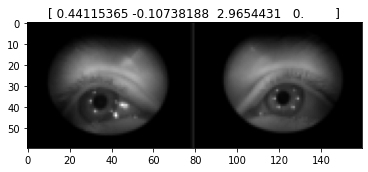

In [24]:
img_transform = transforms.Compose([
    transforms.Resize((h_rs,w_rs)),
    transforms.Grayscale(),
    # transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor()])

full_dataset = EyeTrackingDataset(path_pos = path_pos, dir_images = dir_images, transform=img_transform)


train_length= int(0.7 * len(full_dataset))
val_length = int(0.1 * len(full_dataset))
test_length = len(full_dataset) - train_length - val_length

np.random.seed(1)
train_dataset, val_dataset, test_dataset=torch.utils.data.random_split(full_dataset,(train_length,val_length,test_length))

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, **kwargs)

# Take a look at the data    
img,target,target_fove = train_dataset[0]
plt.imshow(img.numpy()[0].squeeze(),cmap = 'gray')
plt.title(f'{target}')
plt.show()


In [40]:
class Net(nn.Module):
 
    def __init__(self, h_rs, w_rs, args):
        super().__init__()
        self.args = args
#         self.polar = args.polar
        
        self.act = nn.ELU()
        # (1, 60, 160)
        
        self.d1 = 32
        self.conv1 = nn.Conv2d(1, self.d1, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        # (32, 60, 160)
        self.batchNorm1 = nn.BatchNorm2d(self.d1)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout2d1 = nn.Dropout2d(0.9)
        # (32, 30, 80)
        
        self.d2 = 32
        self.conv2 = nn.Conv2d(self.d1, self.d2, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        # (32, 30, 80)
        self.batchNorm2 = nn.BatchNorm2d(self.d2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2d2 = nn.Dropout2d(0.9)
        # (32, 15, 40)
        
        self.d3 = 64
        self.conv3 = nn.Conv2d(self.d2, self.d3, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        # (64, 15, 40)
        self.batchNorm3 = nn.BatchNorm2d(self.d3)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout2d3 = nn.Dropout2d(0.9)
        # (64, 7, 20)
        
        self.d4 = 64
        self.conv4 = nn.Conv2d(self.d3, self.d4, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        # (64, 7, 20)
        self.batchNorm4 = nn.BatchNorm2d(self.d4)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout2d4 = nn.Dropout2d(0.9)
        # (64, 3, 10)
        
        self.fc1 = nn.Linear(1920, 16)
        self.dropout1 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(16, 16)
        self.dropout2 = nn.Dropout(0.8)
        self.fc3 = nn.Linear(16, 3)
        
        self.forward_pass = nn.Sequential(
            self.conv1, self.batchNorm1, self.act, self.pool1, #self.dropout2d1, 
            self.conv2, self.batchNorm2, self.act, self.pool2, #self.dropout2d2, 
            self.conv3, self.batchNorm3, self.act, self.pool3, #self.dropout2d3, 
            self.conv4, self.batchNorm4, self.act, self.pool4, #self.dropout2d4, 
            nn.Flatten(), 
            self.fc1, self.act, 
            self.fc2, self.act, 
            self.fc3
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=args.lr)
        self.scheduler = StepLR(self.optimizer, step_size=args.step, gamma=args.gamma)

#     def __init__(self,h_rs,w_rs,args):
#         super(Net, self).__init__()        
#         self.args = args
        
#         chns = [32, 32, 64, 64]
#         self.kers = [3, 3, 3, 3]
#         self.strides = [1, 1, 1, 1]

#         lin_in_w = self.calculate_size(w_rs)
#         lin_in_h = self.calculate_size(h_rs)

#         self.conv1 = nn.Conv2d(1,       chns[0], self.kers[0], self.strides[0])
#         self.conv2 = nn.Conv2d(chns[0], chns[1], self.kers[1], self.strides[1])
#         self.conv3 = nn.Conv2d(chns[1], chns[2], self.kers[2], self.strides[2])
#         self.conv4 = nn.Conv2d(chns[2], chns[3], self.kers[3], self.strides[3])
        
#         self.fc1 = nn.Linear(chns[-1]*lin_in_h*lin_in_w, 16)
#         self.fc2 = nn.Linear(16, 16)       
#         self.fc3 = nn.Linear(16, 3)
        
#         self.activate = nn.ELU()
#         kdrop = 1
        
#         self.forward_pass = nn.Sequential(
#             self.conv1, nn.BatchNorm2d(chns[0]), self.activate, nn.MaxPool2d(2), nn.Dropout2d(kdrop), 
#             self.conv2, nn.BatchNorm2d(chns[1]), self.activate, nn.MaxPool2d(2), nn.Dropout2d(kdrop), 
#             self.conv3, nn.BatchNorm2d(chns[2]), self.activate, nn.MaxPool2d(2), nn.Dropout2d(kdrop), 
#             self.conv4, nn.BatchNorm2d(chns[3]), self.activate, nn.MaxPool2d(2), nn.Dropout2d(kdrop), 
#             nn.Flatten(), self.fc1, self.activate,
#             self.fc2, self.activate,
#             self.fc3
#         )
        
        self.criterion_train = nn.MSELoss()
        self.criterion_test = nn.MSELoss(reduction='sum')
        # Try different optimzers here [Adadelta, Adam, SGD, RMSprop]
        self.optimizer = optim.Adadelta(self.parameters(), lr=args.lr)
        # self.scheduler = ReduceLROnPlateau(self.optimizer, 'min')
        self.scheduler = StepLR(self.optimizer, step_size=args.step, gamma=args.gamma)
    
    
    def calculate_size(self, size_in):
        # conv_out = (conv_in + 2×padding - kernel_size) / stride +1

        size_out = np.floor((size_in  - self.kers[0] + 1) / 2)
        size_out = np.floor((size_out - self.kers[1] + 1) / 2)
        size_out = np.floor((size_out - self.kers[2] + 1) / 2)
        size_out = np.floor(np.floor((size_out - self.kers[3]) / self.strides[3] +1) / 2)

        return int(size_out)
    
    
    def forward(self, x, target):
       
        output = self.forward_pass(x)
        # for layer in self.forward_pass:
        #     x = layer(x)
        #     print(x.size())
        # output = x
        
            
        if self.training:  
            loss = self.criterion_train(output, target)     

            for param in self.parameters():    # Compute regularization
                loss += self.args.reg_lambda*torch.mean(torch.abs(param))
                
            self.optimizer.zero_grad()               # Clear the gradient              
            loss.backward()                     # Gradient computation
            self.optimizer.step() 
        else:
             loss = self.criterion_test(output, target)     

        return output,loss

        
    def train_iterate(self, device, epoch, train_loader):      
        start_time = time.time()           
        for batch_idx, (data, target, target_fove) in enumerate(train_loader):
            data, target = data.to(device,dtype=torch.float), target[:,:3].to(device,dtype=torch.float)           
            output, loss = self.forward(data, target)                # Make predictions

            if batch_idx % self.args.log_interval == 0:
                print('\nTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
                                
                print('Examples:')
                for i in range(3):
                    print('True:', f'{target[i, :]}', 
                          'Pred:', f'{output[i, :]}')
  
                    # print('Train Max:', f'{data[i][0].max()}')

                total_time = time.time() - start_time
                print(f'Time per {self.args.log_interval} iters: {total_time:.2f}s')
                                               
                
                # self.eval()
                # data = data[:3]
                # target = target[:3]
                # output, loss = self.forward(data, target)                # Make predictions
                
                # print('\nCheck Test: 3 loss: {:.4f}'.format(loss))
                # print('Examples:')
                # for i in range(3):
                #     print('Data:', [f'{data[i][0].mean(axis=0)[d]}' for d in range(25,30)], 
                #           'Pred:', [f'{output.tolist()[i][d]:.3f}' for d in range(3)])
                #     print('Test Max:', f'{data[i][0].max()}')
                
                # self.train()
                
        return loss
           
    def test_iterate(self, device, test_loader):     
        
        test_loss = 0   
        preds = []
        trues = [] 
        
        for batch_idx, (data, target, target_fove) in enumerate(test_loader):
            data, target = data.to(device,dtype=torch.float), target[:,:3].to(device,dtype=torch.float)           
            output, loss = self.forward(data, target)                # Make predictions
            test_loss += loss  # sum up batch loss                        
        
            if self.args.evaluate:
              print(f'Test batch {batch_idx}')              
              trues.append(target.detach().numpy())
              preds.append(output.detach().numpy())
            # if batch_idx == 0:
            #       break
                
        test_loss /= len(test_loader.dataset)
    
        print('\nTest set: Average loss: {:.4f}'.format(test_loss))
        print('Examples:')
        for i in range(3):
            print('True:', [f'{target.tolist()[i][d]:.3f}' for d in range(3)], 
                  'Pred:', [f'{output.tolist()[i][d]:.3f}' for d in range(3)])
                
        return test_loss, trues, preds


In [44]:
model = Net(h_rs,w_rs,args).to(device)

train_batch_losses, val_losses = [],[]

# Training loop   
for epoch in range(4):
    model.train()
    train_batch_loss = model.train_iterate(device,epoch,train_loader)

    model.eval()                       
    with torch.no_grad():
        val_loss, _ , _ = model.test_iterate(device,val_loader)

    # remember best loss and save   
    val_loss = val_loss.cpu().numpy()             
#     if args.save_model and val_loss < best_loss:            
#         best_loss = val_loss           
#         torch.save(model.state_dict(), 'eye_tracking_model.pt')
#         np.save(rfd + 'best_loss.npy', best_loss)
#         best_loss = val_loss

    # record train & val loss for every epoch 
    train_batch_losses.append(train_batch_loss.item())
    val_losses.append(val_loss)



Train Epoch: 0 [0/44800 (0%)]	Loss: 21.6559
Examples:
True: tensor([ 0.4412, -0.1074,  2.9654], device='cuda:0') Pred: tensor([-0.3060, -0.1755, -0.1401], device='cuda:0', grad_fn=<SliceBackward>)
True: tensor([0.9455, 0.1685, 7.7871], device='cuda:0') Pred: tensor([-0.3004, -0.1897, -0.0490], device='cuda:0', grad_fn=<SliceBackward>)
True: tensor([ 0.6293, -0.9653,  4.2305], device='cuda:0') Pred: tensor([-0.2716, -0.1543, -0.0964], device='cuda:0', grad_fn=<SliceBackward>)
Time per 20 iters: 2.30s

Train Epoch: 0 [2560/44800 (6%)]	Loss: 4.3876
Examples:
True: tensor([-0.8007,  0.8126,  6.5944], device='cuda:0') Pred: tensor([-0.2260,  0.0584,  6.4846], device='cuda:0', grad_fn=<SliceBackward>)
True: tensor([ 4.0172, -2.4171,  7.4107], device='cuda:0') Pred: tensor([ 0.3574, -0.4930,  7.0847], device='cuda:0', grad_fn=<SliceBackward>)
True: tensor([-1.8589,  1.8128,  6.4177], device='cuda:0') Pred: tensor([-0.3378,  0.1456,  6.1701], device='cuda:0', grad_fn=<SliceBackward>)
Time per

0.6764171719551086